In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

In [2]:
def openImage(f):
    return cv2.imread(f)

### Avec entraînement sur MNIST et evaluation test sur images Loto

Problème -> Chiffres de 0 à 9, on a pas de 1 à 50

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

Nos images de Loto ayant été rognées en 70x70, on est obligés de resize / rescale les images MNIST qui sont de base en 28x28, en 70x70

In [4]:
tmp = []
for img in x_train:
    res = cv2.resize(img, dsize=(70, 70), interpolation=cv2.INTER_CUBIC)
    tmp.append(res)
    
tmp = np.array(tmp)
x_train = tmp

In [ ]:
# You can either run this cell or the next one which loads the model already trained
"""
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(70,70)))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(51, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.save('handwritten.model')"""

In [5]:
modelhand = tf.keras.models.load_model("handwritten.model")

In [6]:
x_test = []
y_test = []

for classe in range(1,51):
    for num in range(1,10):
        if os.path.isfile(f"ImagesRognees/num{classe}/{classe}_num_{num}.jpg"):
            img = openImage(f"ImagesRognees/num{classe}/{classe}_num_{num}.jpg")[:,:,0]
            img = np.invert(np.array([img]))
            x_test.append(img[0])
            y_test.append(classe)
            
x_test = np.array(x_test)
y_test = np.array(y_test)

L'entraînement sur MNIST a été fait, on essaye d'évaluer sur nos images.

In [7]:
loss, accuracy = modelhand.evaluate(x_test, y_test)

8/8 [==============================] - 1s 9ms/step - loss: 3.9315 - accuracy: 0.0236


Accuracy extrêmement faible avec un entraînement fait sur les chiffres de MNIST...

In [8]:
len(x_test)

254

1/1 [==============================] - 0s 261ms/step


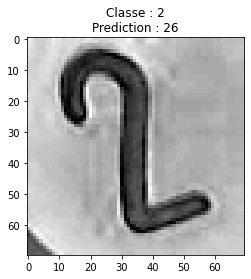

In [10]:
# On a 254 images qu'on a extraites à la main
c = np.random.randint(0,254)
img = x_test[c]
img = np.array([img])

prediction = modelhand.predict(img)
plt.imshow(img[0], cmap=plt.cm.binary)
plt.title(f"Classe : {y_test[c]}\nPrediction : {np.argmax(prediction)}")
plt.show()

### Entraînement sur nos propres images de loto, avec un NN "classique" (non convolutionnel)

In [11]:
x_train = []
y_train = []

for classe in range(1,51):
    for num in range(1,10):
        if os.path.isfile(f"ImagesRognees/num{classe}/{classe}_num_{num}.jpg"):
            img = openImage(f"ImagesRognees/num{classe}/{classe}_num_{num}.jpg")[:,:,0]
            img = np.invert(np.array([img]))
            x_train.append(img[0])
            y_train.append(classe)
            
x_train = np.array(x_train)
y_train = np.array(y_train)

In [12]:
# You can either run this cell or the next one which loads the model already trained

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(70,70)))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(51, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=20, batch_size=100)

model.save('loto.model')

Epoch 1/20
3/3 [==============================] - 2s 53ms/step - loss: 678.5406 - accuracy: 0.0118
Epoch 2/20
3/3 [==============================] - 0s 47ms/step - loss: 917.9334 - accuracy: 0.0197
Epoch 3/20
3/3 [==============================] - 0s 15ms/step - loss: 795.4171 - accuracy: 0.0079
Epoch 4/20
3/3 [==============================] - 0s 22ms/step - loss: 469.5135 - accuracy: 0.0197
Epoch 5/20
3/3 [==============================] - 0s 17ms/step - loss: 439.3865 - accuracy: 0.0157
Epoch 6/20
3/3 [==============================] - 0s 15ms/step - loss: 406.6676 - accuracy: 0.0079
Epoch 7/20
3/3 [==============================] - 0s 13ms/step - loss: 305.0159 - accuracy: 0.0197
Epoch 8/20
3/3 [==============================] - 0s 18ms/step - loss: 175.9952 - accuracy: 0.0315
Epoch 9/20
3/3 [==============================] - 0s 17ms/step - loss: 159.6339 - accuracy: 0.0157
Epoch 10/20
3/3 [==============================] - 0s 22ms/step - loss: 117.7238 - accuracy: 0.0236
Epoch 11/

INFO:tensorflow:Assets written to: loto.model/assets


Toujours une très faible accuracy après l'entraînement...

In [13]:
# En essayant d'évaluer sur les images d'entraînement même (pas très pertinent de base, mais toujours une très faible accuracy)
model.evaluate(x_train, y_train)

8/8 [==============================] - 0s 5ms/step - loss: 3.9313 - accuracy: 0.0197


[3.9313371181488037, 0.019685039296746254]

1/1 [==============================] - 0s 58ms/step


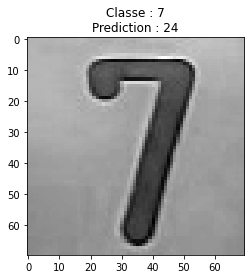

In [15]:
# Test sur une image
img = openImage(f"ImagesRognees/imagesTest/7_test.jpg")[:,:,0]
img = np.invert(np.array([img]))
prediction = model.predict(img)
plt.imshow(img[0], cmap=plt.cm.binary)
plt.title(f"Classe : {7}\nPrediction : {np.argmax(prediction)}")
plt.show()

### Tentatives avec images de lotos uniquement, mais avec augmentation artificielle du nombre d'images

### Sur un CNN (Convolutionnal Neural Network)

In [40]:
x_train = []
y_train = []

for classe in range(1,51):
    for num in range(1,10):
        if os.path.isfile(f"ImagesRognees/num{classe}/{classe}_num_{num}.jpg"):
            img = openImage(f"ImagesRognees/num{classe}/{classe}_num_{num}.jpg")[:,:,0]
            img = np.invert(np.array([img]))
            x_train.append(img[0])
            y_train.append(classe)
            
x_train = np.array(x_train)
y_train = np.array(y_train)

In [41]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator instance for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,      # Rotate the image by a random angle within the specified range
    width_shift_range=0.1,  # Shift the image horizontally by a fraction of its width
    height_shift_range=0.1, # Shift the image vertically by a fraction of its height
    zoom_range=0.1,         # Zoom in or out on the image by a random factor
    horizontal_flip=False,   # Flip the image horizontally
    vertical_flip=False,    # Do not flip the image vertically
    fill_mode='nearest'     # Fill in missing pixels with the nearest value
)

# Reshape x_train to have 4 dimensions (assuming grayscale images)
x_train_augmented = np.reshape(x_train, (-1, 70, 70, 1))

# Initialize an empty array to store augmented images and labels
augmented_images = []
augmented_labels = []

# Generate augmented images
desired_augmentation_size = 60000  # Specify the desired size of the augmented dataset
batch_size = 32  # Specify a reasonable batch size
for x_batch, y_batch in datagen.flow(x_train_augmented, y_train, batch_size=batch_size):
    augmented_images.append(x_batch)
    augmented_labels.append(y_batch)
    if len(augmented_images) * batch_size >= desired_augmentation_size:
        break

# Stack augmented images and labels into single arrays
augmented_images = np.vstack(augmented_images)
augmented_labels = np.hstack(augmented_labels)

# Shuffle augmented data
shuffled_indices = np.random.permutation(len(augmented_images))
x_train_augmented = augmented_images[shuffled_indices]
y_train_augmented = augmented_labels[shuffled_indices]


In [42]:
from sklearn.model_selection import train_test_split

# Split the augmented dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_train_augmented, y_train_augmented, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential()

# Add convolutional layers
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(70, 70, 1)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Flatten layer to transition from convolutional layers to fully connected layers
model.add(tf.keras.layers.Flatten())

# Add dense (fully connected) layers
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(51, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model 5 epochs

#model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))
#model.save("loto_5epochs_training.model")

In [25]:
# Chargement du modèle entrainé sur 5 epochs
model5 = tf.keras.models.load_model("loto_5epochs_training.model")
model5.evaluate(x_test, y_test)

373/373 [==============================] - 10s 26ms/step - loss: 0.2382 - accuracy: 0.9308


[0.23820175230503082, 0.9307969808578491]

In [ ]:
# Train the model 10 epochs

#model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
#model.save("loto_10epochs_training.model")

In [38]:
len(x_test)

11907

In [45]:
# Chargement du modèle entrainé sur 10 epochs
model10 = tf.keras.models.load_model("loto_10epochs_training.model")
model10.evaluate(x_test, y_test)

373/373 [==============================] - 10s 25ms/step - loss: 0.1528 - accuracy: 0.9606


[0.15277226269245148, 0.9606114029884338]

$\textbf{93.22% d'accuracy pour le modèle entrainé sur 5 epochs contre 95.86% pour celui entrainé sur 10 epochs}$

1/1 [==============================] - 0s 55ms/step


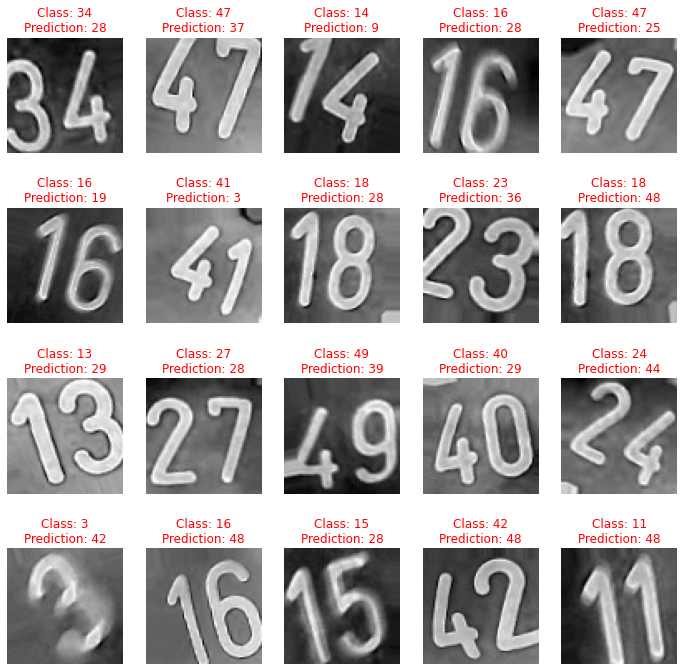

In [46]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
taken = []

for i in range(1,21):
    # Randomly select an index
    c = np.random.randint(0, len(x_test))
    if c in taken:
        while c in taken:
            c = np.random.randint(0, len(x_test))
    taken.append(c)
    
    # Extract the image and invert the pixel values
    img = x_test[c][:,:,0]
    img_inverted = 255 - img  # Invert pixel values

    # Reshape the image array to match the model's input shape
    img_inverted = np.expand_dims(img_inverted, axis=0)
    img_inverted = np.expand_dims(img_inverted, axis=-1)

    # Perform prediction
    prediction = model10.predict(img_inverted)

    # Determine if the prediction is correct
    predicted_class = np.argmax(prediction)
    actual_class = y_test[c]
    is_correct = (predicted_class == actual_class)

    # Display the image and prediction
    plt.subplot(4,5,i)
    plt.imshow(img_inverted[0], cmap=plt.cm.binary)
    title = f"Class: {y_test[c]}\nPrediction: {predicted_class}"
    if is_correct:
        plt.title(title, color='green')
    else:
        plt.title(title, color='red')
    plt.axis("off")

plt.show()


# CONCLUSION DE CES QUELQUES TESTS SUR IMAGES RELLEES LOTO

#### Avec un modèle entraîné sur 5 epochs

Certaines prédictions ont l'air "presque" correct, un chiffre sur 2 de bon ou des chiffres qui se ressemblent... Quelques exemples : 

(-0.5, 198.5, 235.5, -0.5)

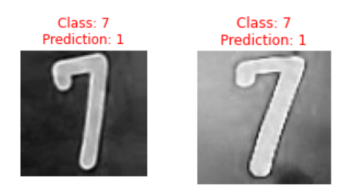

In [28]:
plt.subplot(1,2,1)
plt.imshow(Image.open("presqueok/7_1.png"))
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(Image.open("presqueok/7_1_2.png"))
plt.axis("off")

Avec ces 2 premiers exemples, le 7 a l'air souvent d'être confondu avec le 1. Voici d'avantages de tests avec le 7 et le 1 pour avoir une meilleure idée : 

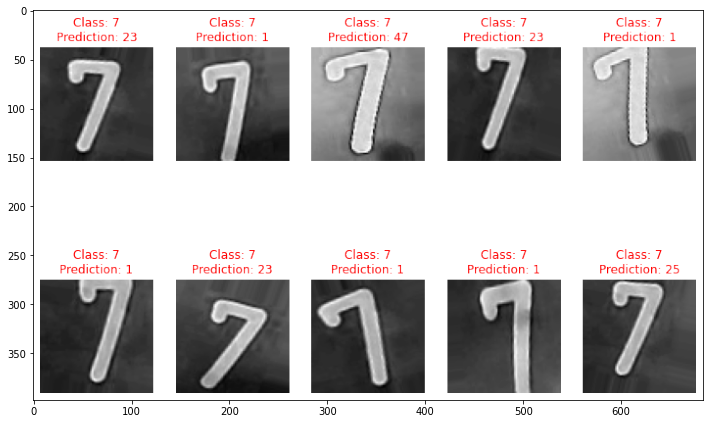

In [29]:
plt.figure(figsize=(12,12))
plt.imshow(Image.open(f"presqueok/sevens.png"))

On voit sur les prédictions ci-dessus que, sur 10 tests, 7 a été prédit 5 fois comme étant un 1, et une fois comme un 47, le 7 a-t-il été confondu avec le 7 de 47 ?

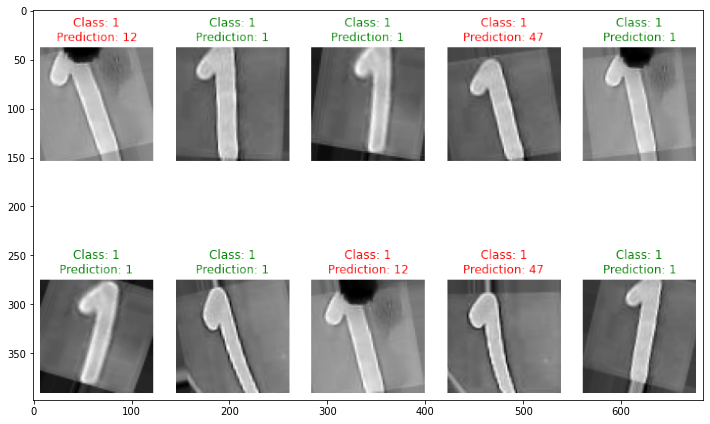

In [30]:
plt.figure(figsize=(12,12))
plt.imshow(Image.open(f"presqueok/ones.png"))

Le 1 semble déjà avoir une meilleure précision, 6 bonnes prédictions, et sur les 4 autres, il a été prédit deux fois 12 (le 1 du 12 peut être), et deux fois 47 (confusion entre 7 et 1 encore une fois probablement)

In [31]:
i711 = Image.open(f"presqueok/7_1.png")
i712 = Image.open(f"presqueok/7_1_2.png")
i96 = Image.open(f"presqueok/9_6.png")
i1646 = Image.open(f"presqueok/16_46.png")
i2029 = Image.open(f"presqueok/20_29.png")
i2425 = Image.open(f"presqueok/24_25.png")
i2829 = Image.open(f"presqueok/28_29.png")
i3036 = Image.open(f"presqueok/30_36.png")

images = [i711,i712,i96,i1646,i2029,i2425,i2829,i3036]

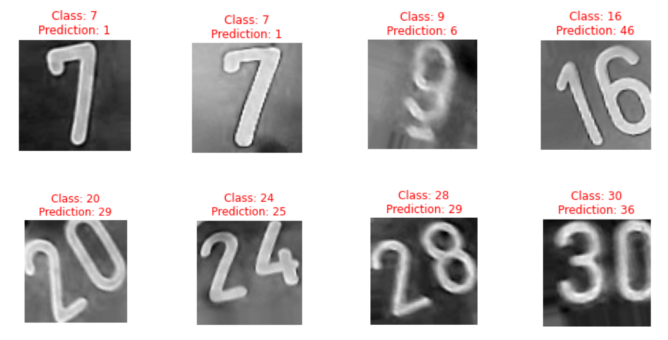

In [32]:
plt.figure(figsize=(12,6))
for i in range(len(images)):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i])
    plt.axis("off")

Image 1 : 7 confondu avec 1

Image 2 : 7 confondu avec 1

Image 3 : 9 confondu avec 6 (rotation ?)

Image 4 : 16 confondu avec 46 (le 6 reconnu, le 1 qui ressemble un peu au 4 ?)

Image 5 : 20 confondu avec 29 (le 2 semble correct, le 0 confondu avec la boucle du 9 ?)

Image 6 : 24 confondu avec 25 (2 correct, 5 confondu 4 ?)

Image 7 : 28 confondu avec 29 (2 correct, la partie "inférieure gauche" du 8 non considérée et donc 9 ?)

Image 8 : 36 confondu avec 36 (le 3 semble correct, le 0 confondu avec la boucle du 6 ?)


# CONCLUSION DE CES QUELQUES TESTS SUR IMAGES RELLEES LOTO

#### Avec un modèle entraîné sur 10 epochs

In [33]:
e10_1 = Image.open("presqueok/10e1.png")
e10_2 = Image.open("presqueok/10e2.png")
e10_3 = Image.open("presqueok/10e3.png")

(-0.5, 683.5, 670.5, -0.5)

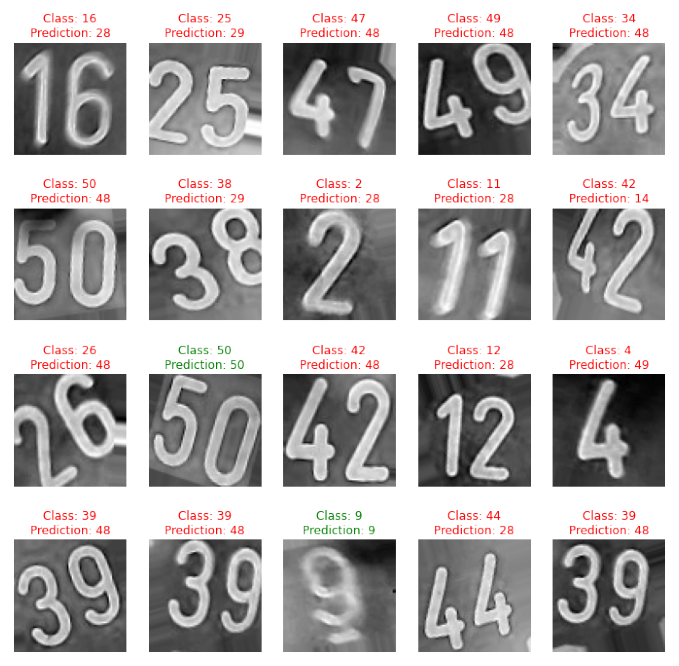

In [34]:
plt.figure(figsize=(12,12))
plt.imshow(e10_1)
plt.axis("off")

(-0.5, 683.5, 670.5, -0.5)

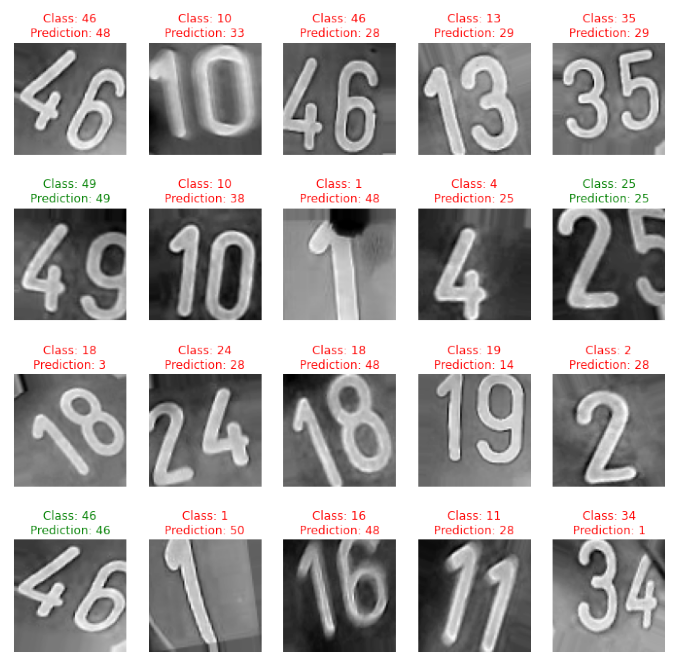

In [35]:
plt.figure(figsize=(12,12))
plt.imshow(e10_2)
plt.axis("off")

(-0.5, 683.5, 670.5, -0.5)

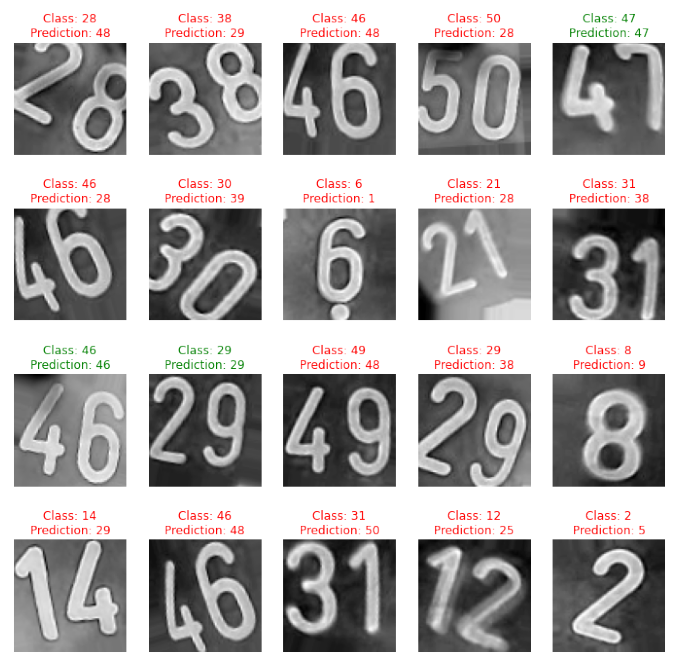

In [36]:
plt.figure(figsize=(12,12))
plt.imshow(e10_3)
plt.axis("off")